In [1]:
#이 파일 셀만 작동시키면 모델 테스트 가능
%cd /content
!git clone https://github.com/yunada03/AI_Opensource.git



/content
Cloning into 'AI_Opensource'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 149 (delta 52), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (149/149), 13.03 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
!git clone https://github.com/jeya-maria-jose/Medical-Transformer.git

import sys
sys.path.append("/content/Medical-Transformer")

# 4) 작업 디렉토리 이동 (dataset과 ipynb가 여기에 있음)
%cd /content/AI_Opensource
!pip install -U scikit-learn
!pip install timm einops nibabel SimpleITK matplotlib opencv-python

Cloning into 'Medical-Transformer'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 166 (delta 40), reused 28 (delta 28), pack-reused 111 (from 1)
Receiving objects: 100% (166/166), 1.19 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/AI_Opensource
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.5 MB/s eta 0:00:00


In [3]:
import sklearn, scipy, torch
print("scikit-learn:", sklearn.__version__)
print("scipy:", scipy.__version__)
print("torch:", torch.__version__)


scikit-learn: 1.7.2
scipy: 1.16.3
torch: 2.8.0+cu126


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os


class FundusDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.images = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        base = os.path.splitext(img_name)[0]
        mask_name = base + "_mask.png"
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # 이미지 및 마스크 로드 + 리사이즈 + 정규화
        image = Image.open(img_path).convert("RGB").resize((self.img_size, self.img_size))
        mask = Image.open(mask_path).convert("L").resize((self.img_size, self.img_size))

        image = np.array(image, dtype=np.float32) / 255.0
        mask = (np.array(mask, dtype=np.float32) > 0.5).astype(np.float32)

        image = torch.tensor(image.transpose(2, 0, 1))     # [C,H,W]
        mask = torch.tensor(mask).unsqueeze(0)             # [1,H,W]

        return image, mask

In [6]:
from lib.models.axialnet import MedT  # 이미 clone된 폴더 기준

dataset = FundusDataset("dataset/images", "dataset/masks", img_size=256)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

model = MedT(img_size=256, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

medt_net(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(8, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): AxialBlock_dynamic(
      (conv_down): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hight_block): AxialAttention_dynamic(
        (qkv_transform): qkv_transform(16, 32, kernel_size=(1,), stride=(1,), bias=False)
        (bn_qkv): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=Tru

In [7]:
#대략 3분
for epoch in range(5):  # 빠르게 확인용: 5 epoch만
    model.train()
    total_loss = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        masks = masks.squeeze(1).long()  # [B, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}/5] Loss: {total_loss/len(loader):.4f}")

torch.save(model.state_dict(), "MedT_fundus_trained_light.pth")
print("학습 완료 및 모델 저장 완료!")

[Epoch 1/5] Loss: 0.5533
[Epoch 2/5] Loss: 0.1488
[Epoch 3/5] Loss: 0.0927
[Epoch 4/5] Loss: 0.0745
[Epoch 5/5] Loss: 0.0490
학습 완료 및 모델 저장 완료!


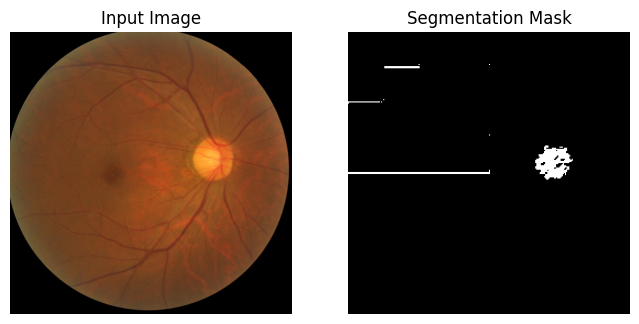

In [10]:
import torchvision.transforms as T
import matplotlib.pyplot as plt


# 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MedT(img_size=256, num_classes=2).to(device)
model.load_state_dict(torch.load("MedT_fundus_trained_light.pth", map_location=device))
model.eval()

# 테스트 이미지 불러오기(n0017이 가장 선명 & n00##에 0~49숫자 넣기)
img = Image.open("dataset/images/n0017.JPG").convert('RGB')
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])
x = transform(img).unsqueeze(0).to(device)

# 예측 수행
with torch.no_grad():
    out = model(x)

    # segmentation만 추출
    if isinstance(out, (tuple, list)):
        seg = out[0]
    else:
        seg = out

    # (B, C, H, W) → (H, W)
    pred = torch.argmax(seg, dim=1).cpu().numpy()[0]

# 시각화
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pred, cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')
plt.show()
